# `timex` example: Cradle-to-grave LCA of an electric vehicle

In [1]:
import bw2data as bd

bd.projects.set_current("bw25_premise")

## Prospective databases

Created using `premise` with updated electricity sectors

In [2]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup


In [3]:
del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.write({})

Getting some input processes with positive and negative carbon dioxide flows


In [4]:
# a process with carbon dioxide to soil flow (uptake by soil)
land_use_change = [act for act in db_2020 if "land already in use, annual cropland to perennial crop" in act["name"] and  act["location"] == "ES"][0]
for exc in land_use_change.biosphere():
    print(exc)

Exchange: 1.8148820400238037 square meter 'Transformation, from arable land, unspecified use' (square meter, None, ('natural resource', 'land')) to 'land already in use, annual cropland to perennial crop' (kilogram, ES, None)>
Exchange: 1.8148820400238037 square meter 'Transformation, to permanent crop' (square meter, None, ('natural resource', 'land')) to 'land already in use, annual cropland to perennial crop' (kilogram, ES, None)>
Exchange: 28.747732162475586 kilogram 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil',)) to 'land already in use, annual cropland to perennial crop' (kilogram, ES, None)>


In [5]:
fg = bd.Database("foreground")

In [6]:
fg.new_node("dummy system", name="dummy system", unit="unit").save()
dummy_node = fg.get("dummy system")
dummy_node.new_edge(input=dummy_node, amount=1, type="production").save()


In [7]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

#add some co2 uptake
land_use_node = dummy_node.new_edge(input=land_use_change, amount=10, type="technosphere")
land_use_node["temporal_distribution"] = TemporalDistribution(
    date=np.array([-10, -5, 0, 5], dtype="timedelta64[Y]"), 
    amount=np.array([0.25, 0.25, 0.25, 0.25])  
)
land_use_node.save()

In [8]:
#adding some co2 emissions
co2_flow=bd.Database("biosphere3").search("Carbon dioxide, fossil")[0]

co2_node = dummy_node.new_edge(input=co2_flow, amount=50, type="biosphere")
co2_node["temporal_distribution"]=TemporalDistribution(
    date=np.array([-8, 8], dtype="timedelta64[Y]"), 
    amount=np.array([0.5, 0.5])  
)
co2_node.save()

## LCA using `timex`

In [9]:
method = ("EF v3.1", "climate change", "global warming potential (GWP100)")

In [10]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [11]:
from timex_lca import TimexLCA

tlca = TimexLCA({dummy_node.key: 1}, method, database_date_dict, cutoff=1e-9)

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timex_lca.py:86: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 1


In [12]:
tlca.build_timeline()

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timeline_builder.py:317: Warning: Reference date 2014-01-01 00:00:00 is lower than all provided dates. Data will be taken from the closest higher year.
  warnings.warn(
c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timeline_builder.py:317: Warning: Reference date 2019-01-01 00:00:00 is lower than all provided dates. Data will be taken from the closest higher year.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2014-01-01,"land already in use, annual cropland to perenn...",2024-01-01,dummy system,2.5,{'db_2020': 1}
1,2019-01-01,"land already in use, annual cropland to perenn...",2024-01-01,dummy system,2.5,{'db_2020': 1}
2,2024-01-01,"land already in use, annual cropland to perenn...",2024-01-01,dummy system,2.5,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
3,2024-01-01,dummy system,2024-01-01,-1,1.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
4,2029-01-01,"land already in use, annual cropland to perenn...",2024-01-01,dummy system,2.5,"{'db_2020': 0.09991787571858746, 'db_2030': 0...."


In [13]:
tlca.lci()

In [14]:
tlca.static_lcia()
tlca.score

-237.47732162475586

In [15]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_TH=False) # default characterization function dictionaries mapping to biosphere3 flows from static LCIA method now calculated inside the method

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:58: UserWarning: No custom dynamic characterization functions provided. 
Using default dynamic characterization functions for CO2, CH4, N2O, CO with decay functions from IPCC AR6. 
The selected biosphere flows for these GHGs are based on the selection of the currently chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)') and their matrix ids can be looked up with .characterization_functions.keys()
  warnings.warn(


,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2014-01-01 00:00:00,0.000000e+00,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",0.000000e+00
1,2015-01-01 05:49:12,-1.183833e-13,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-1.183833e-13
2,2016-01-01 01:26:24,0.000000e+00,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-1.183833e-13
3,2016-01-01 11:38:24,-1.111291e-13,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-2.295124e-13
4,2016-12-31 07:15:36,4.118006e-14,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-1.883323e-13
...,...,...,...,...,...,...,...
696,2128-01-02 00:10:48,-1.800239e-31,1170,"Carbon dioxide, fossil",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-2.108455e-11
695,2128-01-02 00:10:48,-5.034345e-14,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-2.108455e-11
697,2128-12-31 11:06:00,1.759567e-14,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-2.106696e-11
698,2129-12-31 16:55:12,1.755357e-14,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-2.104940e-11


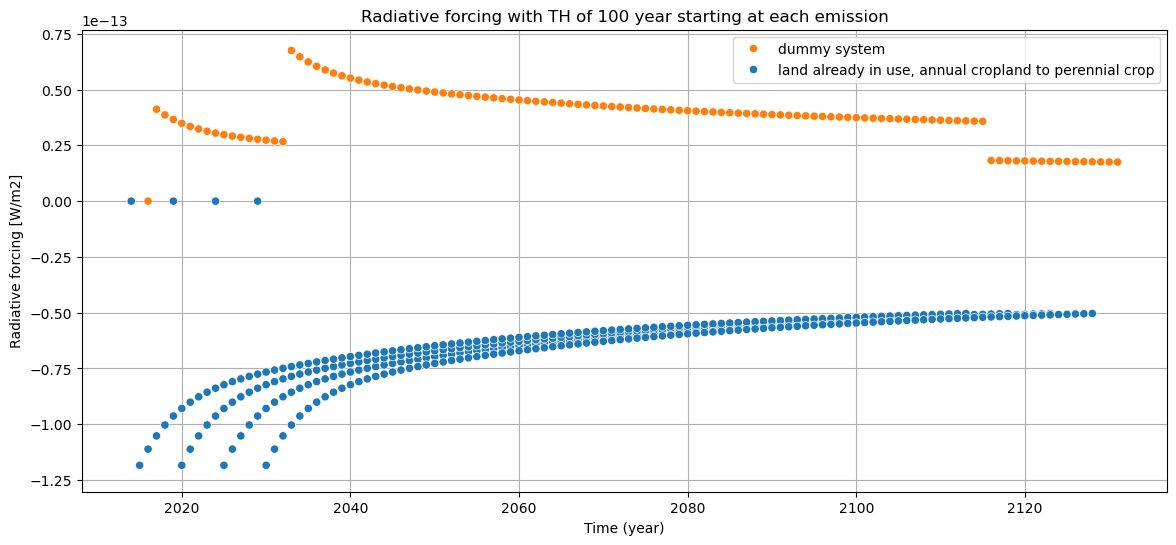

In [16]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True) #jump in orange dots comes from summing up the emissions within the activity=True

In [17]:
tlca.dynamic_lcia(metric="GWP", fixed_TH=False) #negative flows for biogenic CO2 uptake

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:58: UserWarning: No custom dynamic characterization functions provided. 
Using default dynamic characterization functions for CO2, CH4, N2O, CO with decay functions from IPCC AR6. 
The selected biosphere flows for these GHGs are based on the selection of the currently chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)') and their matrix ids can be looked up with .characterization_functions.keys()
  warnings.warn(
c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:212: UserWarning: Using timex' default co2 characterization function for GWP reference.
  warnings.warn(
c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:212: UserWarning: Using timex' default co2 characterization function for GWP reference.
  warnings.warn(
c:\users\mullera\onedrive - v

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2014-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-71.869330
1,2016-01-01 01:26:24,2.500000e+01,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-46.869330
2,2019-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-118.738661
3,2024-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-190.607991
4,2029-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-262.477322
5,2029-01-01 00:00:00,-2.569987e-16,1170,"Carbon dioxide, fossil",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-262.477322
6,2031-12-31 22:33:36,2.500000e+01,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-237.477322


In [18]:
tlca.characterized_inventory

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2014-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-71.869330
1,2016-01-01 01:26:24,2.500000e+01,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-46.869330
2,2019-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-118.738661
3,2024-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-190.607991
4,2029-01-01 00:00:00,-7.186933e+01,3636,"Carbon dioxide, to soil or biomass stock",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-262.477322
5,2029-01-01 00:00:00,-2.569987e-16,1170,"Carbon dioxide, fossil",39919,"(db_2020, a72f0604c64853d294b3010497d0d38d)",-262.477322
6,2031-12-31 22:33:36,2.500000e+01,1170,"Carbon dioxide, fossil",98280,"(foreground, dummy system)",-237.477322


In [19]:
tlca.dynamic_inventory_characterizer.characterization_functions #available functions

{1169: (<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False, negative_sign: bool | None = False) -> pandas.core.frame.DataFrame>,
  False),
 1170: (<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False, negative_sign: bool | None = False) -> pandas.core.frame.DataFrame>,
  False),
 1168: (<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False, negative_sign: bool | None = False) -> pandas.core.frame.DataFrame>,
  False),
 1171: (<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False, negative_sign: bool | None = False) -> pandas.core.frame.DataFrame>,
  False),
 112: (<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False, 

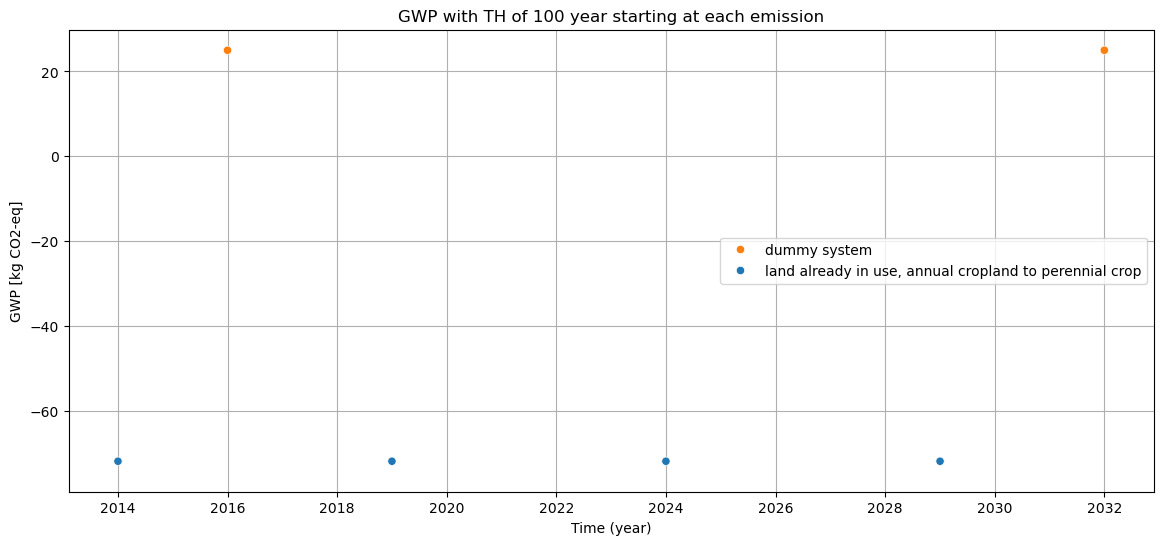

In [ ]:
tlca.plot_dynamic_characterized_inventory(
    sum_emissions_within_activity=True, cumsum=False
)

In [28]:
tlca.plot_dynamic_characterized_inventory(
    sum_emissions_within_activity=True, cumsum=False
)

#TODO understand why it doesn't work in this cell

UnknownObject: 